<a href="https://colab.research.google.com/github/vothane/tripleplay/blob/master/tripleplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
import numpy as np
import os.path
import warnings

warnings.filterwarnings('ignore')

Using TensorFlow backend.


Run this cell only if you do not already have the image data.

***Recommend that you not run this on your own machine.***

In [2]:
!git clone https://github.com/vothane/tripleplay.git
!mv tripleplay/imgs imgs
!rm -rf tripleplay

Cloning into 'tripleplay'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 134 (delta 19), reused 104 (delta 3), pack-reused 0
Receiving objects: 100% (134/134), 12.03 MiB | 31.50 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [3]:
f = lambda img_file : img_to_array(load_img('imgs/{}'.format(img_file), color_mode = "grayscale"))
pitcher_map = {img_file[:-4] : f(img_file)
              for img_file in os.listdir('imgs/')}
print(np.shape(pitcher_map['Chris_Sale']))

(600, 600, 1)


In [4]:
image_size = 600 # x=y

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

W0626 22:48:50.385101 140533271549824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 22:48:50.456219 140533271549824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 22:48:50.458453 140533271549824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 600, 600, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440000)           0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                23040016  
Total params: 23,058,832
Trainable params: 23,058,832
Non-trainable params: 0
_________________________________________________________________


In [5]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1440000)           24480000  
_________________________________________________________________
reshape_1 (Reshape)          (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 300, 300, 64)      36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 600, 600, 32)      18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 600, 600, 1)       289       
Total params: 24,535,681
Trainable params: 24,535,681
Non-trainable params: 0
________________________________________________________________

In [6]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 600, 600, 1)       0         
_________________________________________________________________
encoder (Model)              (None, 16)                23058832  
_________________________________________________________________
decoder (Model)              (None, 600, 600, 1)       24535681  
Total params: 47,594,513
Trainable params: 47,594,513
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

train_data = np.array([data for _, data in pitcher_map.items()])

autoencoder.fit(train_data, train_data, epochs=15, batch_size=batch_size)

W0626 22:48:50.810441 140533271549824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0626 22:48:51.140457 140533271549824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0626 22:48:51.462164 140533271549824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/15
96/96 [==============================] - 69s 714ms/step - loss: 1378.1788
Epoch 2/15
96/96 [==============================] - 62s 647ms/step - loss: 1374.7737
Epoch 3/15
96/96 [==============================] - 62s 649ms/step - loss: 1374.6569
Epoch 4/15
96/96 [==============================] - 62s 646ms/step - loss: 1374.5693
Epoch 5/15
96/96 [==============================] - 62s 650ms/step - loss: 1374.5337
Epoch 6/15
96/96 [==============================] - 62s 650ms/step - loss: 1374.5334
Epoch 7/15
96/96 [==============================] - 62s 650ms/step - loss: 1374.5356
Epoch 8/15
96/96 [==============================] - 62s 646ms/step - loss: 1374.5376
Epoch 9/15
96/96 [==============================] - 62s 651ms/step - loss: 1374.5399
Epoch 10/15
96/96 [==============================] - 62s 651ms/step - loss: 1374.5417
Epoch 11/15
96/96 [==============================] - 64s 667ms/step - loss: 1374.5434
Epoch 12/15
96/96 [==============================] - 62s 644ms/

# Motivation for using tSNE

AI (hate that term) is neither good nor evil. But they do reflect on our society. Including social bias, unfairness and discrimination. Mostly unintentional, either by laziness or carelessness. Sometimes with malicious intent, for example ***Palantir***, the most perverse use of this technology.

I’m not going too much into the societal implications but will introduce some tools and strategies to weed out undesirable learning dynamics. 


In [8]:
from sklearn.manifold import TSNE

deep_features = encoder.predict(train_data, batch_size=batch_size)

tsne  = TSNE(n_components=2)
X_embedded = tsne.fit_transform(deep_features)
tsne.fit_transform(deep_features[1].reshape(-1, 1))
X_embedded

array([[ 2.266743  ,  1.8748215 ],
       [ 6.4675245 ,  5.6747947 ],
       [ 5.454368  ,  4.6279    ],
       [-5.370978  , -5.6865797 ],
       [-0.7857964 , -2.4933896 ],
       [ 4.0466375 ,  3.2154295 ],
       [ 7.016533  ,  5.787903  ],
       [-3.340935  , -4.456921  ],
       [ 7.337003  ,  6.049678  ],
       [-3.5227113 , -3.8691154 ],
       [ 7.080848  ,  5.8263965 ],
       [ 1.4812675 ,  0.94911325],
       [ 7.105132  ,  5.861829  ],
       [-3.5377    , -3.5716324 ],
       [ 5.3195243 ,  4.7197704 ],
       [ 2.5770552 ,  2.1803896 ],
       [ 2.940535  ,  2.3687122 ],
       [-2.5323339 , -3.0057855 ],
       [-2.2485745 , -3.0816    ],
       [ 6.1062512 ,  4.8951674 ],
       [-0.6831906 , -1.9267231 ],
       [-5.739695  , -5.7015915 ],
       [-3.9344504 , -3.8312273 ],
       [-1.8258736 , -2.9464798 ],
       [ 3.3654351 ,  3.049862  ],
       [ 4.528379  ,  4.0250025 ],
       [ 5.016556  ,  3.8720353 ],
       [ 0.06592868, -1.0092382 ],
       [ 0.20906883,

Really this is basically nearest neighbors where closet points are pitchers who closely resemble each other. I need to
graph these points and label them with pitchers names to make sense of it all. after that we can ascertain what these 
deep features may be, right now there are 16 and we can use ensemble algos to find an optimal number after words. i'm guessing something like arm slot (3/4 or overhand) and left/right handedness. 

At second glance, features like arm slot (3/4 or overhand) and left/right handedness are actually linear regression features and should be learned at the topmost hidden layer. This is apparent by visual inspection, where data points can be "regressed" with straight diagonal line. \ line would indicate right-handed pitcher and / would be "southpaws". Whereas angle of the line indicates arm-slot.

Having said this, these simple features should still be inherent in non-linear complex features found in deeper hidden layers. For example, fastballs that have movement couldn't be linear regress by location, but should still be in the same region corresponding to pitching hand and arm slot.

Use K-Means clustering to see how many types of pitchers (categories) we have.

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(random_state=0).fit(X_embedded)
len(kmeans.cluster_centers_)

8

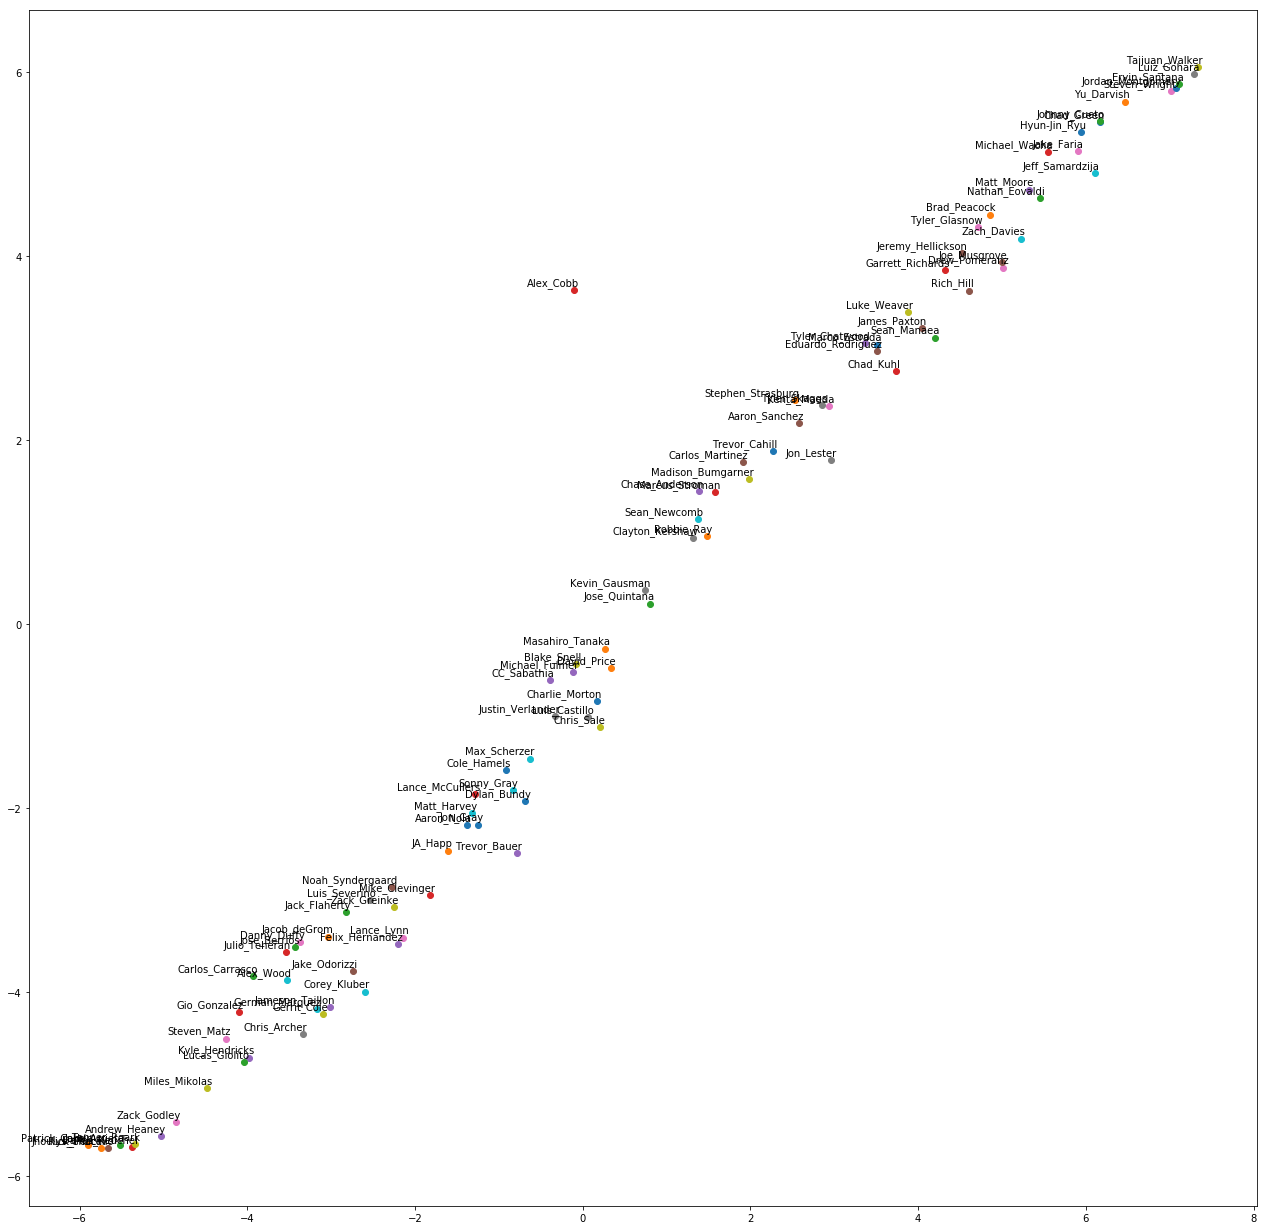

In [19]:
import matplotlib.pyplot as plt

names = np.array([pitcher for pitcher, _ in pitcher_map.items()])

x = []
y = []

for value in X_embedded:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(22, 22))    

for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(names[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
     
plt.show()

### This plot is interesting in that there is an *overriding latent feature* that puts all pitchers in a uniform linear line from bottom to upper right. Right now it is a big mystery to me. Keep in mind that we are comparing pitchers by location of their pitching arsenal, things like velocity, grip and etc aren't in play.